<a href="https://colab.research.google.com/github/FawwazMayda/BangkitPlantPathology/blob/master/BaselineVGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.0.2)
Processing /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01/kaggle-1.5.6-py3-none-any.whl
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [0]:
import os
os.environ['KAGGLE_USERNAME']="alvinsenjaya"
os.environ['KAGGLE_KEY']="f226b7958d8018810d2a29d209d02e43"

In [3]:
!kaggle competitions download -c plant-pathology-2020-fgvc7

plant-pathology-2020-fgvc7.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip plant-pathology-2020-fgvc7.zip

Archive:  plant-pathology-2020-fgvc7.zip
replace images/Test_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: images/Test_0.jpg       
  inflating: images/Test_1.jpg       
  inflating: images/Test_10.jpg      
  inflating: images/Test_100.jpg     
  inflating: images/Test_1000.jpg    
  inflating: images/Test_1001.jpg    
  inflating: images/Test_1002.jpg    
  inflating: images/Test_1003.jpg    
  inflating: images/Test_1004.jpg    
  inflating: images/Test_1005.jpg    
  inflating: images/Test_1006.jpg    
  inflating: images/Test_1007.jpg    
  inflating: images/Test_1008.jpg    
  inflating: images/Test_1009.jpg    
  inflating: images/Test_101.jpg     
  inflating: images/Test_1010.jpg    
  inflating: images/Test_1011.jpg    
  inflating: images/Test_1012.jpg    
  inflating: images/Test_1013.jpg    
  inflating: images/Test_1014.jpg    
  inflating: images/Test_1015.jpg    
  inflating: images/Test_1016.jpg    
  inflating: images/Test_1017.jpg    
  inflating: image

In [0]:
from tqdm import tqdm
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [0]:
submission = pd.read_csv("sample_submission.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [7]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [8]:
test.sample(5)

,image_id
1559,Test_1559
59,Test_59
1575,Test_1575
1475,Test_1475
730,Test_730


In [9]:
submission.sample(5)

,image_id,healthy,multiple_diseases,rust,scab
1157,Test_1157,0.25,0.25,0.25,0.25
1057,Test_1057,0.25,0.25,0.25,0.25
1593,Test_1593,0.25,0.25,0.25,0.25
1768,Test_1768,0.25,0.25,0.25,0.25
226,Test_226,0.25,0.25,0.25,0.25


In [10]:
!ls

images				sample_data	       test.csv
plant-pathology-2020-fgvc7.zip	sample_submission.csv  train.csv


In [11]:
train_img = []
path = "./images"
for im in tqdm(train['image_id']):
  im = im+".jpg"
  fnpath = os.path.join(path,im)
  img = cv2.imread(fnpath)
  img = cv2.resize(img,(224,224))
  img = img.astype('float32')
  train_img.append(img)

100%|██████████| 1821/1821 [00:55<00:00, 32.86it/s]


In [12]:
test_img = []
path = "./images"
for im in tqdm(test['image_id']):
  im = im+".jpg"
  fnpath = os.path.join(path,im)
  img = cv2.imread(fnpath)
  img = cv2.resize(img,(224,224))
  img = img.astype('float32')
  test_img.append(img)

100%|██████████| 1821/1821 [00:56<00:00, 32.50it/s]


In [0]:
train_label = train.iloc[:,1:]
train_img = np.array(train_img)
test_img = np.array(test_img)

In [14]:
print(train_img.shape)
print(train_label.shape)
print(test_img.shape)

(1821, 224, 224, 3)
(1821, 4)
(1821, 224, 224, 3)


Creating Data generator

In [0]:
import tensorflow as tf

In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip = True,
        )
        
datagen.fit(train_img)

In [17]:
base = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg')
base.trainable = False
model = tf.keras.models.Sequential()
model.add(base)
model.add(tf.keras.layers.Dense(100, 'relu'))
model.add(tf.keras.layers.Dense(4, 'softmax'))

58892288/58889256 [==============================] - 0s 0us/step


In [0]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                         factor = 0.1,
                                         patience = 2,
                                         cooldown = 0,
                                         min_lr = 0.00001,
                                         verbose = 1)

callbacks = [reduce_lr]
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
training = model.fit(datagen.flow(train_img,train_label), batch_size=32, epochs=20, callbacks=callbacks, steps_per_epoch=200)
#model.fit_generator(datagen.flow(train_img, train_label, batch_size=32), epochs=20, callbacks=callbacks)

Epoch 1/20
200/200 [==============================] - 77s 387ms/step - loss: 0.8643 - accuracy: 0.6833 - lr: 0.0010
Epoch 2/20
200/200 [==============================] - 76s 381ms/step - loss: 0.5864 - accuracy: 0.7862 - lr: 0.0010
Epoch 3/20
200/200 [==============================] - 77s 383ms/step - loss: 0.5000 - accuracy: 0.8158 - lr: 0.0010
Epoch 4/20
200/200 [==============================] - 77s 384ms/step - loss: 0.4519 - accuracy: 0.8300 - lr: 0.0010
Epoch 5/20
200/200 [==============================] - 76s 380ms/step - loss: 0.4188 - accuracy: 0.8463 - lr: 0.0010
Epoch 6/20
200/200 [==============================] - 76s 381ms/step - loss: 0.3860 - accuracy: 0.8580 - lr: 0.0010
Epoch 7/20
200/200 [==============================] - 76s 382ms/step - loss: 0.3706 - accuracy: 0.8601 - lr: 0.0010
Epoch 8/20
200/200 [==============================] - 76s 382ms/step - loss: 0.3289 - accuracy: 0.8762 - lr: 0.0010
Epoch 9/20
200/200 [==============================] - 76s 381ms/step - l

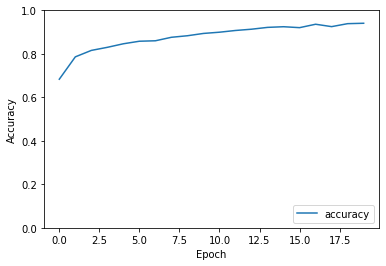

In [20]:
plt.plot(training.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [0]:
y_pred = model.predict(test_img)
submission.loc[:,'healthy':'scab'] = y_pred

In [22]:
print(submission.head())
submission.to_csv('submission.csv', index=False)

  image_id   healthy  multiple_diseases      rust      scab
0   Test_0  0.617336       6.464445e-06  0.319979  0.062678
1   Test_1  0.445111       2.071011e-05  0.464528  0.090340
2   Test_2  0.000047       6.779049e-04  0.000653  0.998622
3   Test_3  0.999991       7.667204e-11  0.000005  0.000003
4   Test_4  0.000015       3.416424e-07  0.995032  0.004952


In [23]:
!kaggle competitions submit -c plant-pathology-2020-fgvc7 -f submission.csv -m "LB Sub"

100% 165k/165k [00:08<00:00, 20.2kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7

Kaggle submission score: 0.781